# UK-High Value Customers Identification

## 0.0 Planning

### 0.0.1 Input

1. Business Problem
    * Select high value customers that will be eligible to a loyalty program.
2. Dataset
    * One year of sales data.

### 0.0.2 Output


1. Relation of clients elegible to the loyalty program.

    client_id | is_elegible? |<br>
     10323&emsp;&emsp;1<br>
     32413&emsp;&emsp;0
        
        
2. Report containing the answers to the business problems.

    1. Who are the eligible customers for participating the loyalty program?
    2. How many customers will be part of the program?
    3. What are the main characteristics of these customers?
    4. What is the percentage of contribution of the participants of this loyalty program?
    5. What is the expected revenue of loyalty program to the next months?
    6. In what conditions someone becomes elegible?
    7. In what conditions someone becomes ineligible?
    8. What guarantees the group chosen is better than a random cluster?
    9. What actions can the marketing team take to increase revenue?

### 0.0.3 Tasks

1. Who are the eligible customers for participating the loyalty program?
    - What eligible means? What is customer value?
    - Revenue:
        - High average ticket
        - High LTV
        - Low recency
        - High basket size
        - Low churn probability
        - High LTV prediction
        - High buying propensity
    
    
    - Costs:
        Low devolution rate
        
    - Shopping experience:
        High average ratings
        
        
2. How many customers will be part of the program?
    - % of customers in eligible to the loyalty program


3. What are the main characteristics of these customers
    - Customer characteristics
    - Consumption characteristics


4. What is the percentage of contribution of the participants of this loyalty program?
    - Total revenue
    - Total of eligible customers' revenue


5. What is the expected revenue of loyalty program to the next months?
    - LTV of the eligible customers
    - Cohort analysis


6. In what conditions someone becomes elegible?
    - Define periodicity
    - The person needs to be similar to the eligible people


7. In what conditions someone becomes ineligible?
    - Define periodicity
    - The person needs to be dissimilar to the eligible people


8. What guarantees the group chosen is better than a random cluster?
    - A/B test
    - A/B Bayesian test
    - Hyphotesis test


9. What actions can the marketing team take to increase revenue?
    - Discount
    - Purchase preference
    - Free Shipping
    - Company tour

## 0.0.4 Benchmark

1. RFM Model

# 0.0 Libraries

In [1]:
!pip install plotly

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

from plotly.express import scatter_3d

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [4]:
df_raw = pd.read_csv('data/Ecommerce.csv', sep=',', decimal='.')

In [5]:
df_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0 Data description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [7]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [9]:
print('The dataset has {} rows and {} columns.'.format(*df1.shape))

The dataset has 541909 rows and 8 columns.


## 1.3 Data types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NANs

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NANs

In [12]:
df1 = df1.dropna(subset=['description', 'customer_id'])

In [13]:
print('# of {} rows before and # of {} rows after \'dropna\'. We removed {:.2f}% of rows of the dataset.'.format(df_raw.shape[0], df1.shape[0], (1-df1.shape[0]/df_raw.shape[0])*100))

# of 541909 rows before and # of 406829 rows after 'dropna'. We removed 24.93% of rows of the dataset.


In [14]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change data types

In [15]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

In [16]:
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive statistics

# 2.0 Feature engineering

In [17]:
df2 = df1.copy()

In [18]:
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [19]:
# Gross Revenue = Quantity * Price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# 3.0 Data filtering

In [20]:
#df3

# 4.0 Exploratory Data Analysis

In [21]:
#df4

# 5.0 Data Preparation

In [22]:
#df5

# 6.0 Feature selection

In [23]:
#df6

# 7.0 Hyper-parameter fine-tuning

In [24]:
#X = df6.drop(columns=['customer_id'])
X = df_ref.drop(columns=['customer_id'])

In [25]:
clusters = [2,3,5,9,13,15]

## 7.1 Withing-Cluster Sum of Squares (WSS)

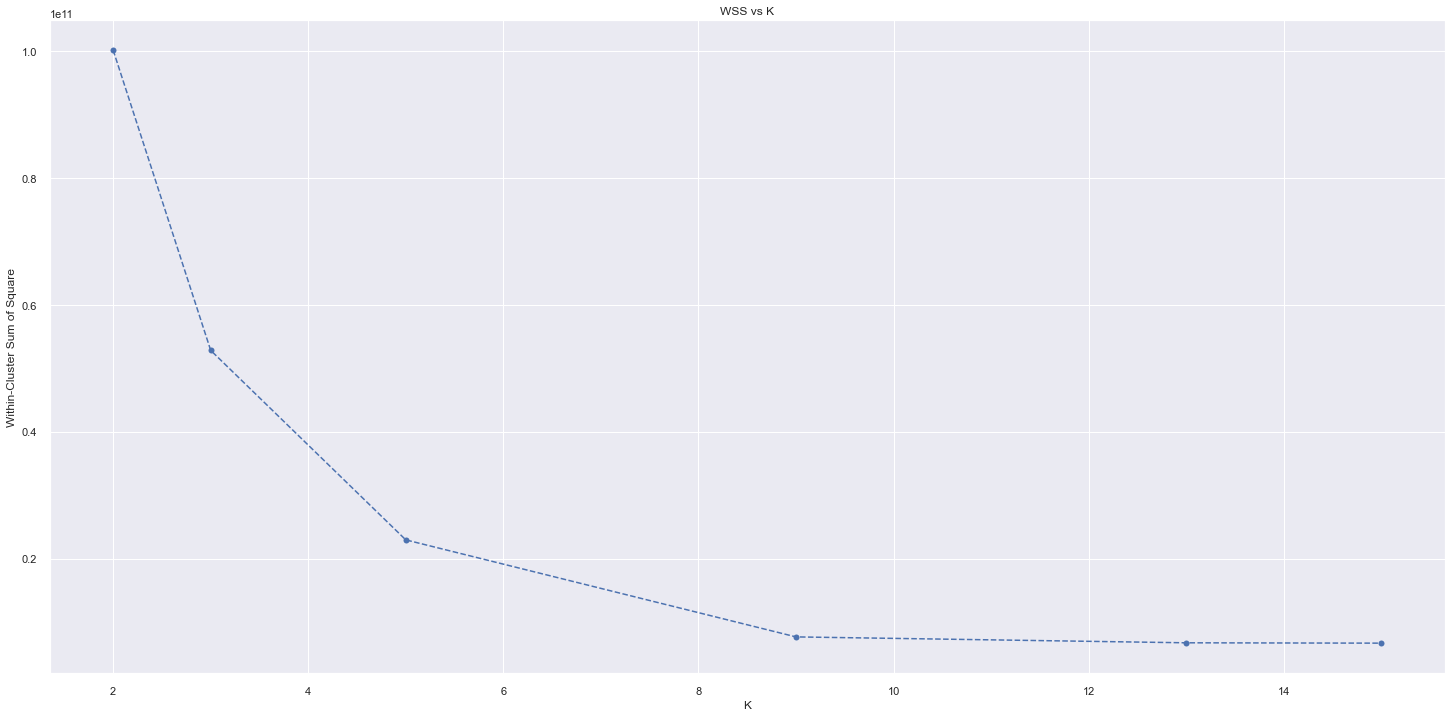

In [26]:
wss = []
for k in clusters:
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K');

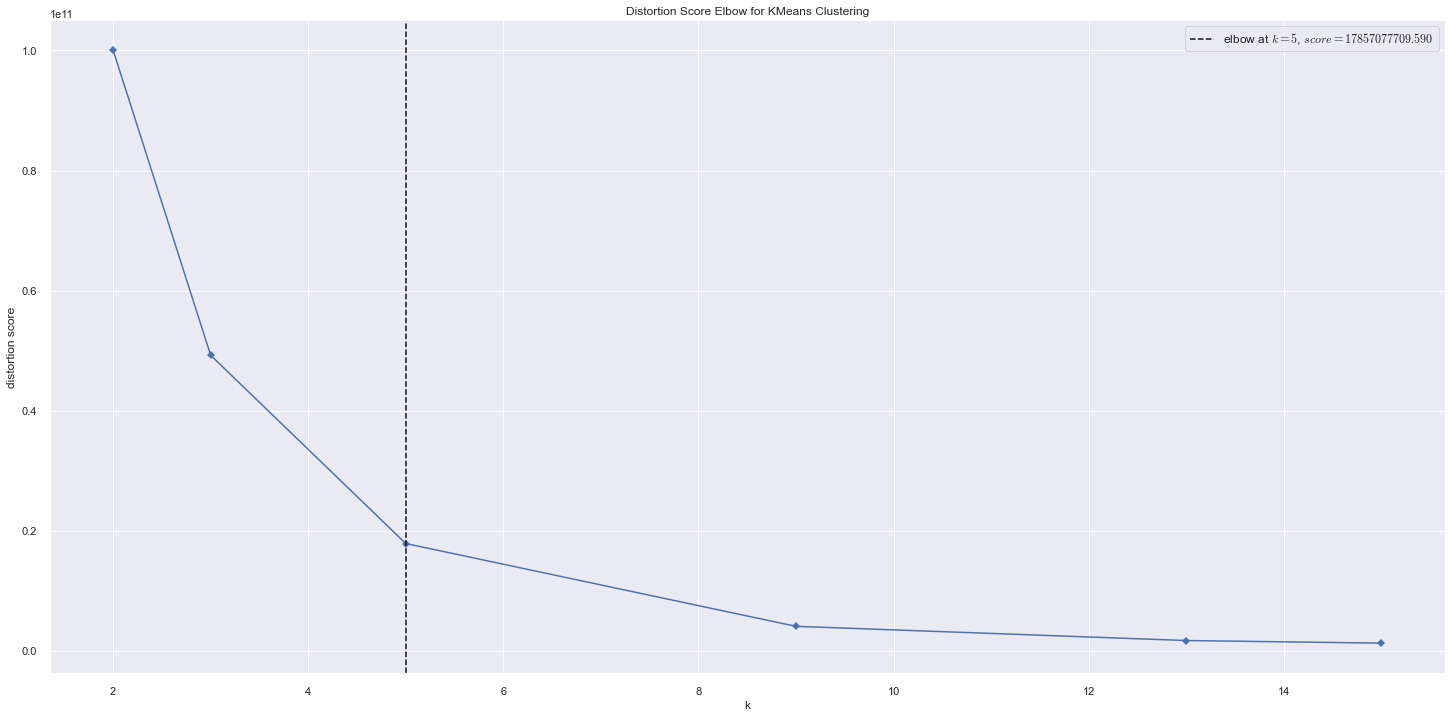

In [27]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

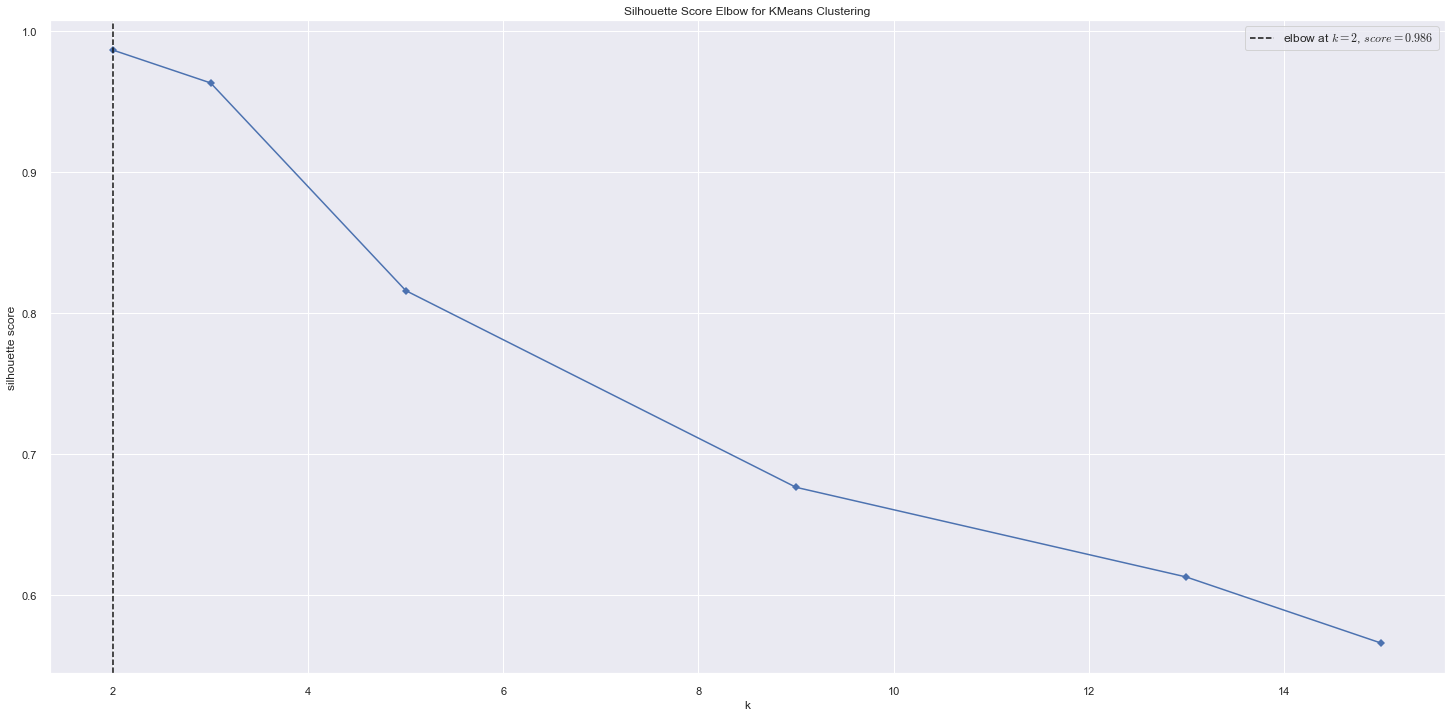

In [28]:
kmeans = KElbowVisualizer(KMeans(), metric='silhouette', k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

# 8.0 Model training

## 8.1 $k$-Means

In [37]:
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df_ref['cluster'] = labels

## 8.2 Cluster Validation

In [30]:
print('WSS value:', kmeans.inertia_)

WSS value: 52830442008.00694


In [31]:
print('Silhouette score:', silhouette_score(X, labels, metric='euclidean'))

Silhouette score: 0.9494677566681544


## 9.0 Cluster analysis

## 9.1 Visualization Inspection

In [38]:
fig = scatter_3d(df_ref, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 Cluster Profile

In [39]:
df_cluster = df_ref[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

df_avg_gross_revenue = df_ref[['gross_revenue', 'cluster']].groupby('cluster').mean

,cluster,customer_id
0,0,4335
1,1,6
2,2,31


In [55]:
df_customers_by_cluster = df_ref[['cluster', 'customer_id']].groupby('cluster').count().reset_index()
df_customers_by_cluster.columns = ['cluster', '#_customers']
df_customers_by_cluster['%_customers'] = 100*(df_customers_by_cluster['#_customers']/df_customers_by_cluster['#_customers'].sum())

df_avg = df_ref[['cluster', 'gross_revenue', 'recency_days', 'invoice_no']].groupby('cluster').mean().reset_index()
df_avg.columns = ['cluster', 'avg_gross_revenue', 'avg_recency_days', 'avg_amount_purchased']

df_cluster = pd.merge(df_customers_by_cluster, df_avg, how='inner', on='cluster')
df_cluster

,cluster,#_customers,%_customers,avg_gross_revenue,avg_recency_days,avg_amount_purchased
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


- Summary:

    - Cluster 0:
        - Number of Customers: 4335 (99.15%)
        - Avg. Recency: 92 days
        - Avg. Amount Purchased: 5
        - Avg. Gross Revenue: $1.372,57

    - Cluster 1:
        - Number of Customers: 6 (0.13%)
        - Avg. Recency: 7 days
        - Avg. Amount Purchased: 89
        - Avg. Gross Revenue: $182.181,98

    - Cluster 2:
        - Number of Customers: 31 (0.70%)
        - Avg. Recency: 13 days
        - Avg. Amount Purchased: 53
        - Avg. Gross Revenue: $40.543,51

# 10.0 Deploy